In [51]:
%pip install xgboost


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy

In [53]:
df = pd.read_csv("./wildfire_dataset.csv")
df

,fire_year,fire_number,fire_name,current_size,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,industry_identifier_desc,...,distance_from_water_source,first_bucket_drop_date,bh_fs_date,bh_hectares,uc_fs_date,uc_hectares,to_fs_date,to_hectares,ex_fs_date,ex_hectares
0,2021,HWF053,NaN,5.50,C,59.522139,-119.926971,Provincial Land,Lightning,NaN,...,NaN,NaN,6/28/21 22:26,0.01,7/1/21 13:26,10.00,NaN,NaN,7/1/21 13:44,5.50
1,2021,RWF005,NaN,0.01,A,52.692262,-116.118960,Provincial Land,Forest Industry,NaN,...,NaN,NaN,3/30/21 14:30,0.01,3/30/21 14:30,0.01,3/30/21 14:35,0.01,4/9/21 8:30,0.01
2,2021,LWF014,NaN,0.10,A,55.937050,-110.719950,Indian Reservation,Incendiary,NaN,...,NaN,NaN,4/16/21 16:57,0.10,4/16/21 16:57,0.10,NaN,NaN,4/17/21 14:15,0.10
3,2021,MWF002,NaN,0.01,A,56.425933,-111.160750,Indian Reservation,Resident,NaN,...,NaN,NaN,4/17/21 15:20,0.01,4/17/21 15:20,0.01,NaN,NaN,4/17/21 15:24,0.01
4,2021,EWF014,NaN,7.13,C,53.693450,-116.058633,Private Land,Resident,NaN,...,NaN,NaN,4/1/21 19:10,7.13,4/2/21 11:00,7.13,4/2/21 15:52,7.13,4/12/21 14:30,7.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22909,2006,CWF231,NaN,0.10,A,51.161883,-114.869317,Indian Reservation,Resident,NaN,...,NaN,NaN,3/11/07 17:35,0.01,3/11/07 17:45,0.01,NaN,NaN,3/11/07 18:00,0.10
22910,2006,CWF232,NaN,0.01,A,51.084150,-115.392633,Provincial Park,Undetermined,NaN,...,NaN,NaN,3/19/07 10:25,0.01,3/19/07 10:25,0.01,NaN,NaN,3/19/07 10:40,0.01
22911,2006,CWF233,NaN,0.70,B,51.333900,-114.997667,Provincial Land,Recreation,NaN,...,NaN,NaN,3/26/07 2:00,0.70,3/26/07 2:00,0.70,NaN,NaN,3/26/07 12:00,0.70
22912,2006,CWF234,NaN,0.01,A,51.071467,-115.316300,Provincial Land,Resident,NaN,...,NaN,NaN,3/28/07 11:00,0.01,3/28/07 11:00,0.01,NaN,NaN,3/28/07 11:30,0.01


Dictionaries:

In [54]:
FSA_dict = {'C': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'E': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'H': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'G': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'L': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'M': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'P': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'R': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'S': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'W': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]}

causes_dict =  {'C': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'E': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'H': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'G': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'L': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'M': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'P': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'R': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'S': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'W': {'general_c': 0, 'activity_c': 0, 'true_c': 0}}

Initialize the Causes Dictionary

In [55]:
g_causes = {}
a_causes = {}
t_causes = {}

for index in df.index:
    general = df.loc[index, 'general_cause_desc']
    activity = df.loc[index, 'activity_class']
    true_c = df.loc[index, 'true_cause']

    if (general not in g_causes):
        g_causes[general] = [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]
    if (activity not in a_causes):
        a_causes[activity] = [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]
    if (true_c not in t_causes):
        
        t_causes[true_c] = [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]

for key, value in causes_dict.items():
    causes_dict[key]['general_c'] = copy.deepcopy(g_causes)
    causes_dict[key]['activity_c'] = copy.deepcopy(a_causes)
    causes_dict[key]['true_c'] = copy.deepcopy(t_causes)

Fill the Dictionaries

In [56]:
weighted_FSA = {'C': 0, 'E': 0, 'H': 0, 'G': 0, 'L': 0, 'M': 0, 'P': 0, 'R': 0, 'S': 0, 'W': 0}

for index in df.index: 

    region = df.loc[index, 'fire_number']
    region = region[:1]
    FSA_dict[region][0] +=1
    classtemp = df.loc[index, 'size_class']
    FSA_dict[region][1][classtemp] += 1
    size = df.loc[index, 'current_size']
    weighted_FSA[region] += size

    general = df.loc[index, 'general_cause_desc']
    causes_dict[region]['general_c'][general][0] += 1
    causes_dict[region]['general_c'][general][1][classtemp] += 1
    activity = df.loc[index, 'activity_class']
    causes_dict[region]['activity_c'][activity][0] += 1
    causes_dict[region]['activity_c'][activity][1][classtemp] += 1
    true_c = df.loc[index, 'true_cause']
    causes_dict[region]['true_c'][true_c][0] += 1
    causes_dict[region]['true_c'][true_c][1][classtemp] += 1

In [57]:
g_causes_list = list(g_causes.keys())
a_causes_list = list(a_causes.keys())
t_causes_list = list(t_causes.keys())
ge = {}
ac = {}
tr = {}

for index in range(len(g_causes_list)):
    ge[g_causes_list[index]] = 0
for index in range(len(a_causes_list)):
    ac[a_causes_list[index]] = 0
for index in range(len(t_causes_list)):
    tr[t_causes_list[index]] = 0

size_general_dict = {'A': ge, 'B': ge, 'C': ge, 'D': ge, 'E': ge}
size_activity_dict = {'A': ac, 'B': ac, 'C': ac, 'D': ac, 'E': ac}
size_true_dict = {'A': tr, 'B': tr, 'C': tr, 'D': tr, 'E': tr}

size_general_dict = {key: copy.deepcopy(ge) for key, value in size_general_dict.items()}
size_activity_dict = {key: copy.deepcopy(ac) for key, value in size_activity_dict.items()}
size_true_dict = {key: copy.deepcopy(tr) for key, value in size_true_dict.items()}


for key,value in causes_dict.items():
    for l,t in value['general_c'].items():
        temp = 0
        for k,v in t[1].items():
            size_general_dict[k][l] += v
    
    for l,t in value['activity_c'].items():
        temp = 0
        for k,v in t[1].items():
            size_activity_dict[k][l] += v
    for l,t in value['true_c'].items():
        temp = 0
        for k,v in t[1].items():
            size_true_dict[k][l] += v

for key, value in size_activity_dict.items():
    size_activity_dict[key].pop(np.nan)

for key, value in size_true_dict.items():
    size_true_dict[key].pop(np.nan)

print(size_general_dict)
print(size_activity_dict)
print(size_true_dict)


{'A': {'Lightning': 4398, 'Forest Industry': 303, 'Incendiary': 1082, 'Resident': 2661, 'Recreation': 4837, 'Agriculture Industry': 288, 'Government': 69, 'Power Line Industry': 751, 'Oil & Gas Industry': 254, 'Undetermined': 439, 'Railroad': 56, 'Other Industry': 211, 'Under Investigation': 0, 'Prescribed Fire': 10, 'Restart': 43}, 'B': {'Lightning': 2467, 'Forest Industry': 93, 'Incendiary': 792, 'Resident': 1081, 'Recreation': 318, 'Agriculture Industry': 159, 'Government': 39, 'Power Line Industry': 351, 'Oil & Gas Industry': 130, 'Undetermined': 239, 'Railroad': 61, 'Other Industry': 72, 'Under Investigation': 0, 'Prescribed Fire': 6, 'Restart': 17}, 'C': {'Lightning': 564, 'Forest Industry': 14, 'Incendiary': 89, 'Resident': 172, 'Recreation': 58, 'Agriculture Industry': 39, 'Government': 3, 'Power Line Industry': 44, 'Oil & Gas Industry': 12, 'Undetermined': 45, 'Railroad': 8, 'Other Industry': 8, 'Under Investigation': 0, 'Prescribed Fire': 1, 'Restart': 3}, 'D': {'Lightning': 

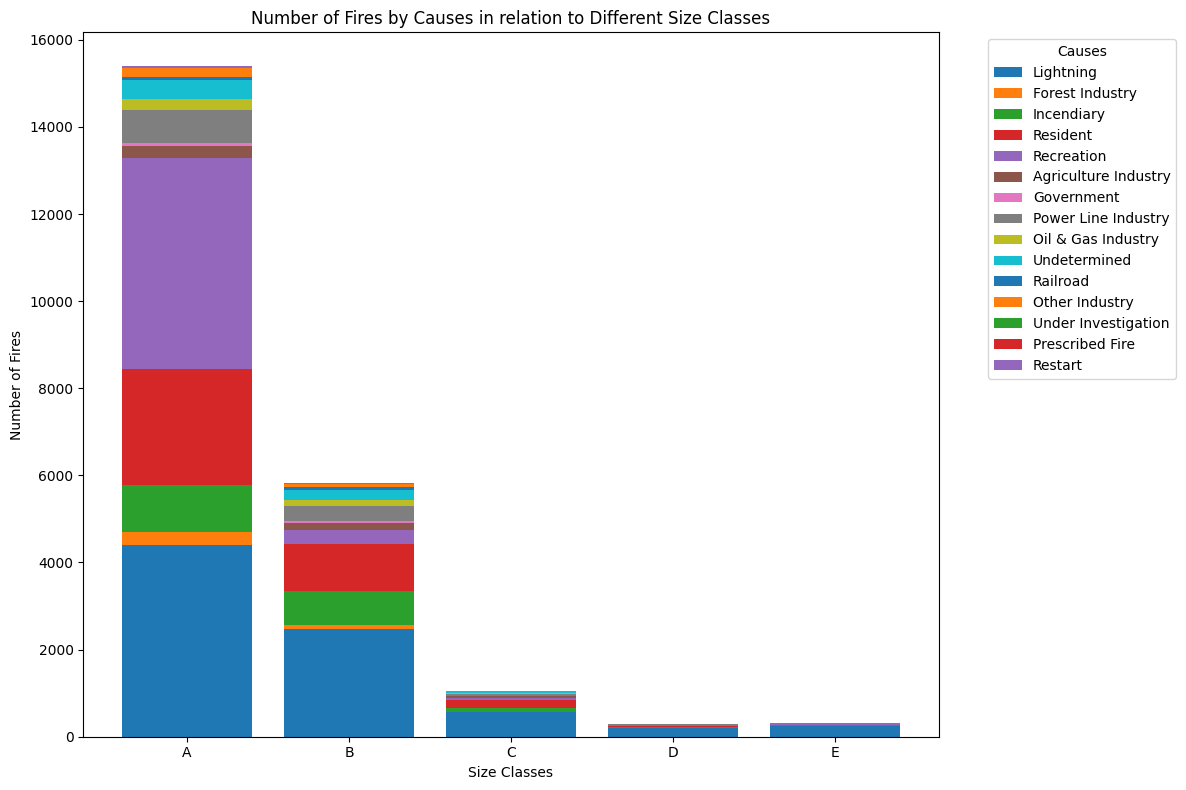

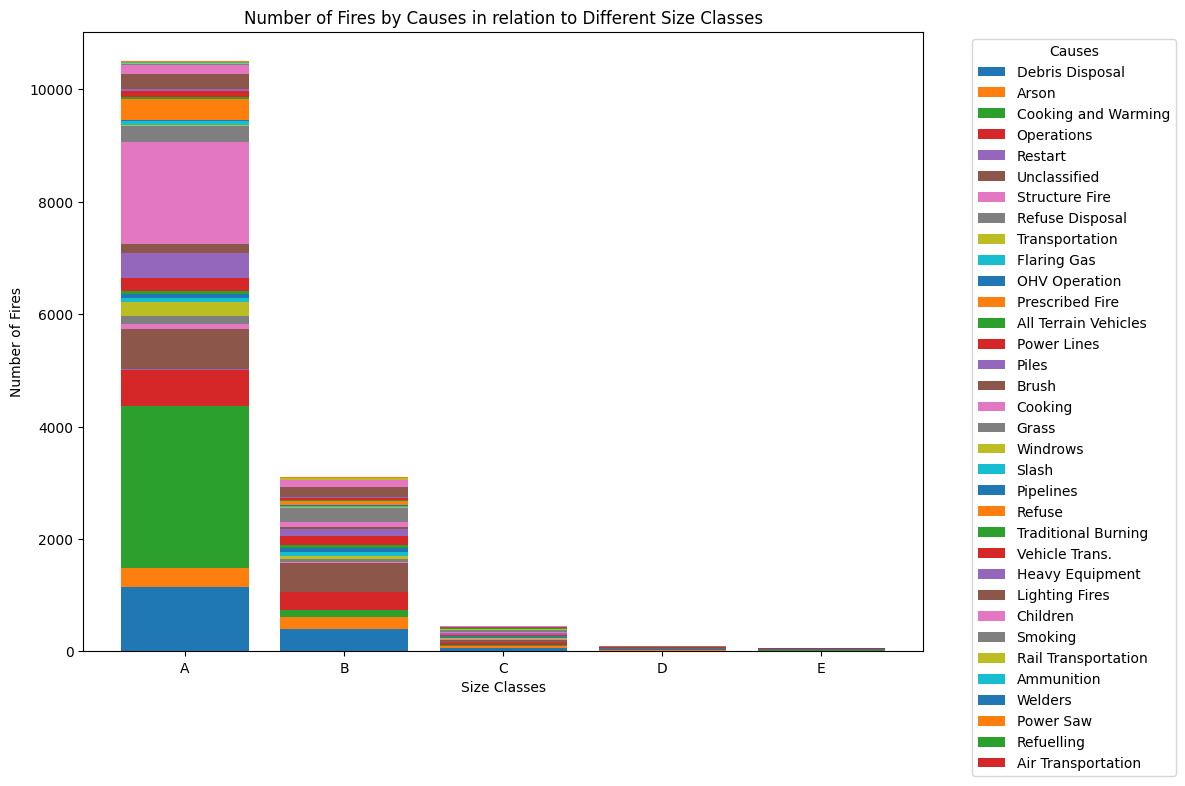

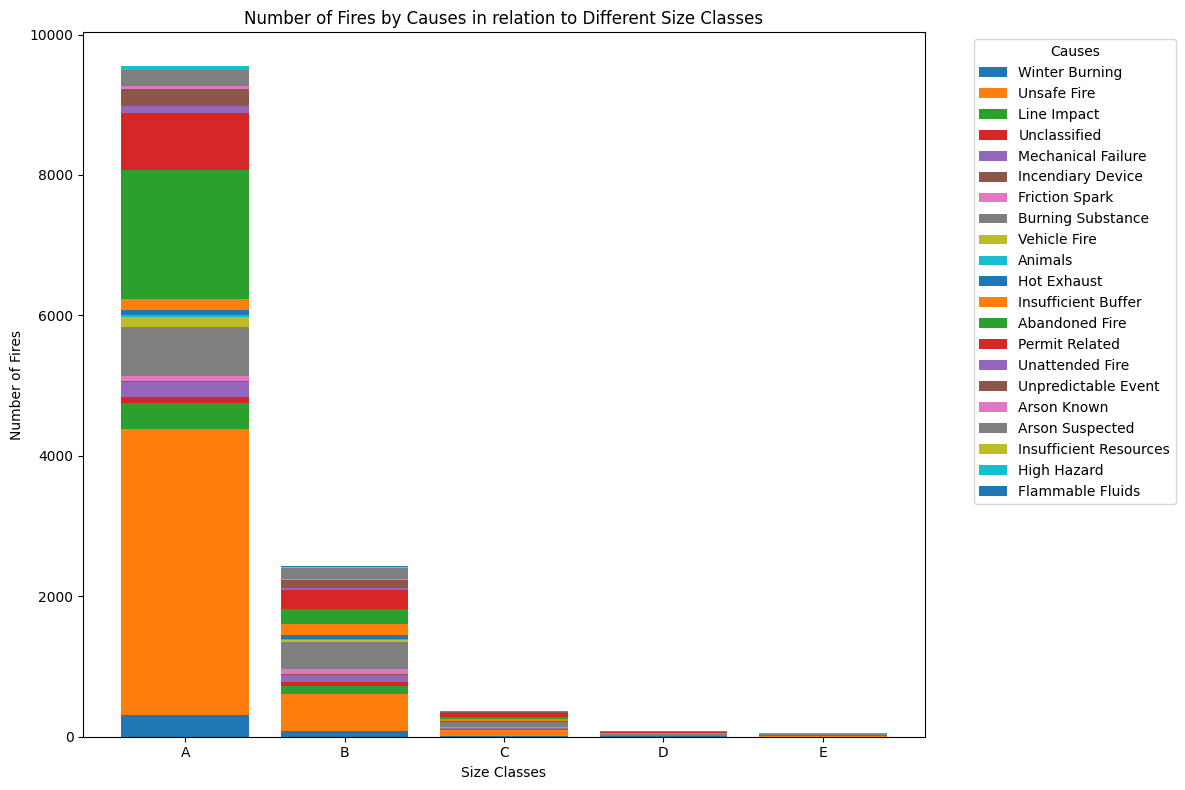

In [58]:
def draw_stacked(size_dict):
    categories = list(size_dict['A'].keys())
    subcategories = list(size_dict.keys())

    fig, ax = plt.subplots(figsize=(12, 8))

    bottom_values = [0] * len(subcategories)

    for category in categories:
        values = [size_dict[subcategory][category] for subcategory in subcategories]
        ax.bar(subcategories, values, label=category, bottom=bottom_values)
        bottom_values = [bottom + value for bottom, value in zip(bottom_values, values)]

    ax.set_xlabel('Size Classes')
    ax.set_ylabel('Number of Fires')
    ax.set_title('Number of Fires by Causes in relation to Different Size Classes')
    ax.legend(title='Causes', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

draw_stacked(size_general_dict)
draw_stacked(size_activity_dict)
draw_stacked(size_true_dict)

In [59]:
g_causes_total = {}
a_causes_total = {}
for key,value in causes_dict.items():
    temp = {}
    for k,v in value['general_c'].items():
        try:
            temp[k] = v[0]
        except(KeyError):
            break
    g_causes_total[key] = temp

a_causes_total = {}
for key,value in causes_dict.items():
    temp = {}
    for k,v in value['activity_c'].items():
        try:
            temp[k] = v[0]
        except(KeyError):
            break
    a_causes_total[key] = temp


t_causes_total = {}
for key,value in causes_dict.items():
    temp = {}
    for k,v in value['true_c'].items():
        try:
            temp[k] = v[0]
        except(KeyError):
            break
    t_causes_total[key] = temp

for key, value in a_causes_total.items():
    a_causes_total[key].pop(np.nan)

for key, value in t_causes_total.items():
    t_causes_total[key].pop(np.nan)

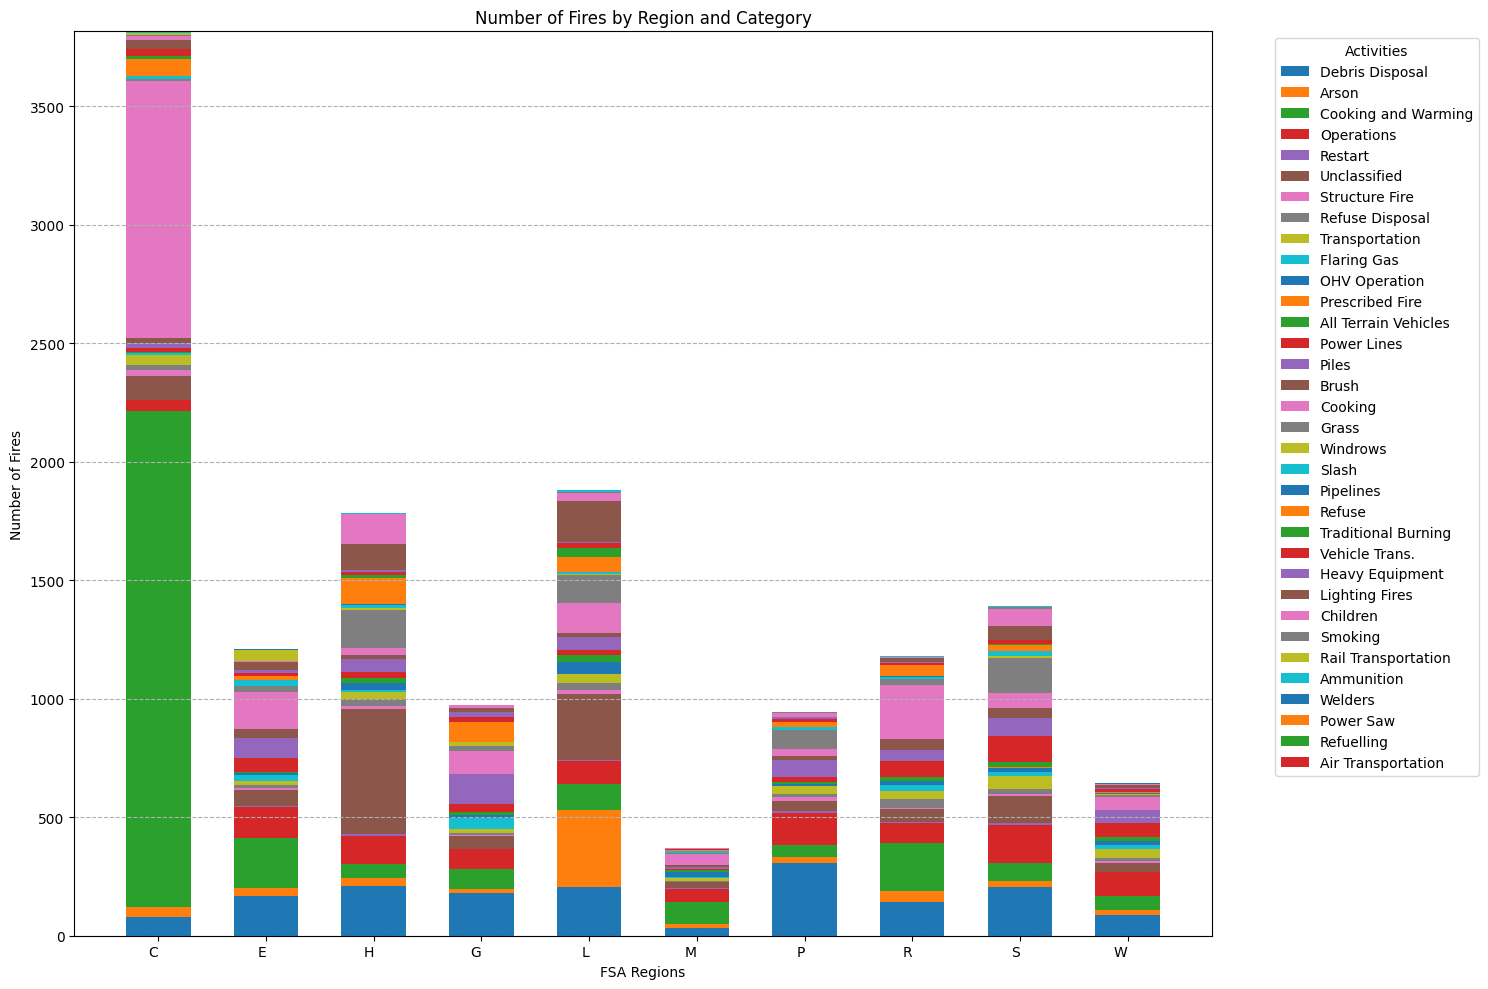

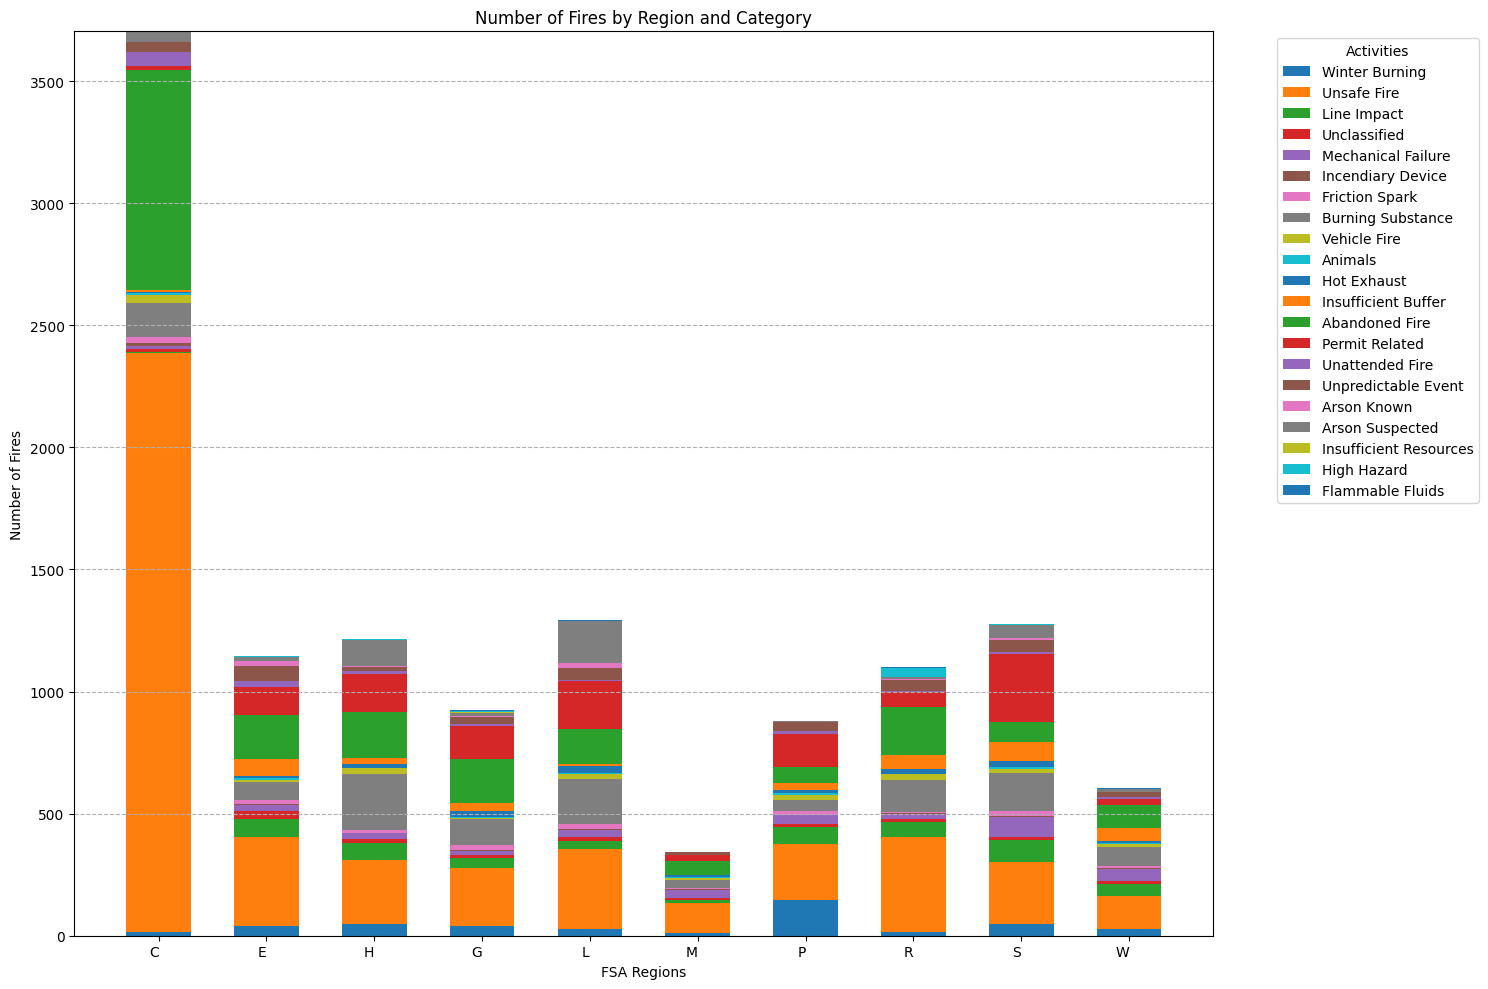

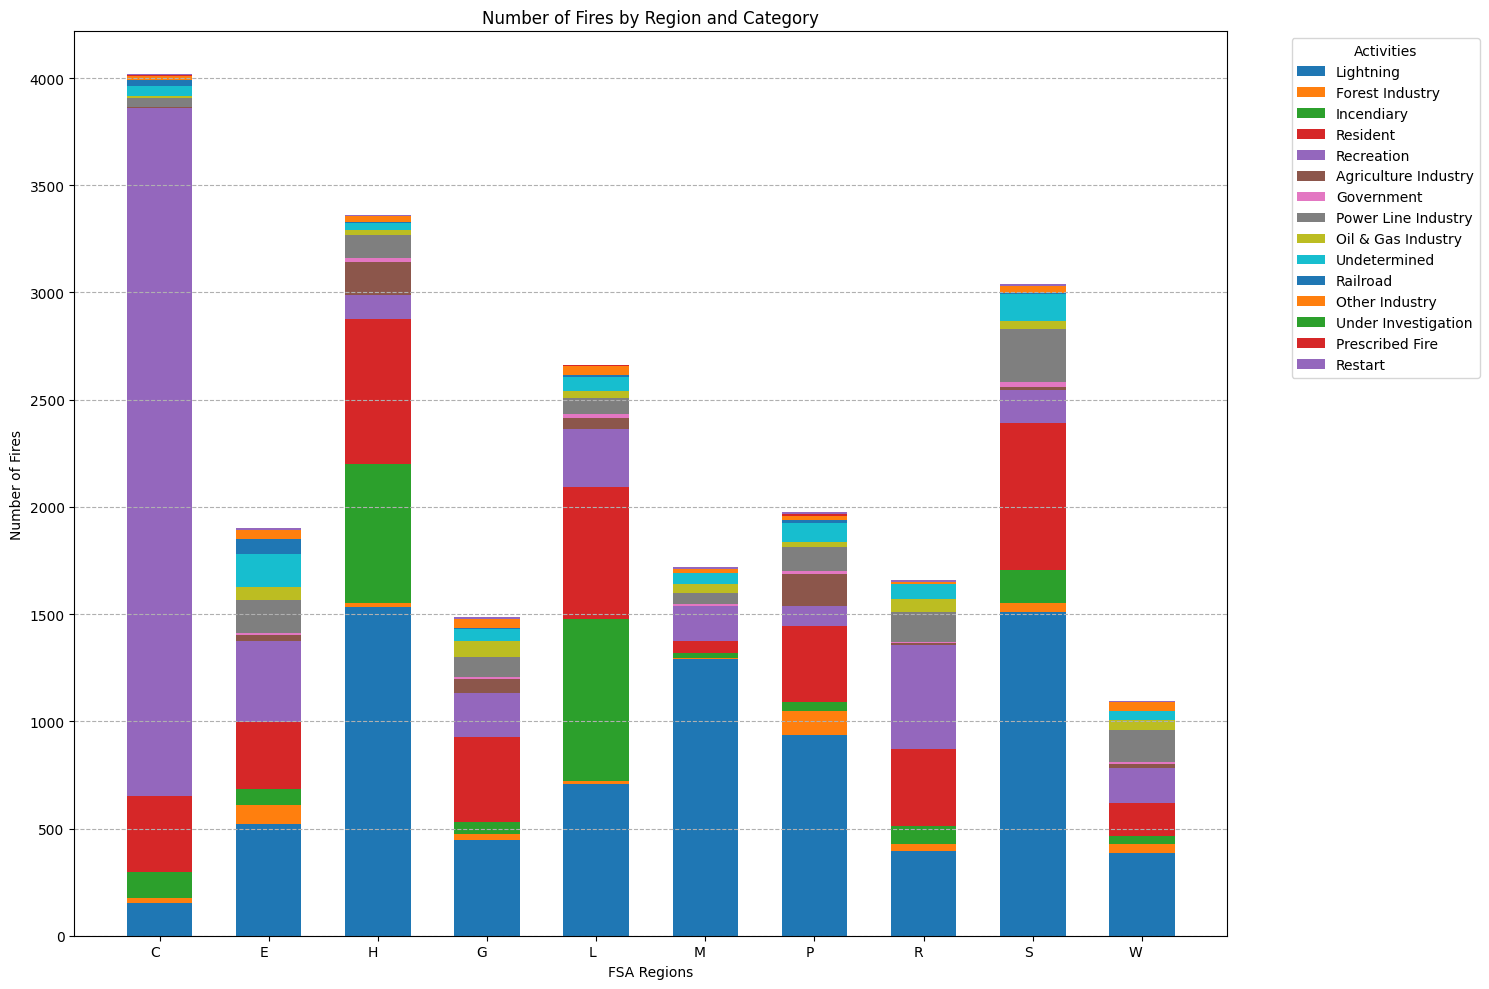

In [60]:
def plot_fires_by_region_and_category(causes_total):
    categories = list(causes_total['C'].keys())
    labels = list(causes_total.keys())

    fig, ax = plt.subplots(figsize=(15, 10))
    bar_width = 0.6

    for i, category in enumerate(categories):
        values = [causes_total[label][category] for label in labels]
        bottom_values = [sum(causes_total[label][categories[j]] for j in range(i)) for label in labels]

        ax.bar(labels, values, width=bar_width, label=category, bottom=bottom_values)

    ax.set_ylabel('Number of Fires')
    ax.set_xlabel('FSA Regions')
    ax.set_title('Number of Fires by Region and Category')
    ax.legend(title='Activities', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--')
    plt.show()


plot_fires_by_region_and_category(a_causes_total)

plot_fires_by_region_and_category(t_causes_total)

plot_fires_by_region_and_category(g_causes_total)

4017
1901
3362
1486
2663
1719
1975
1657
3039
1095
[1.252213094349205, 22.034139926354126, 327.3264069006595, 4.955248990578835, 35.49276380022435, 954.0115590459619, 49.66469873417669, 10.963379601689496, 176.0353109575535, 11.525105022831127]


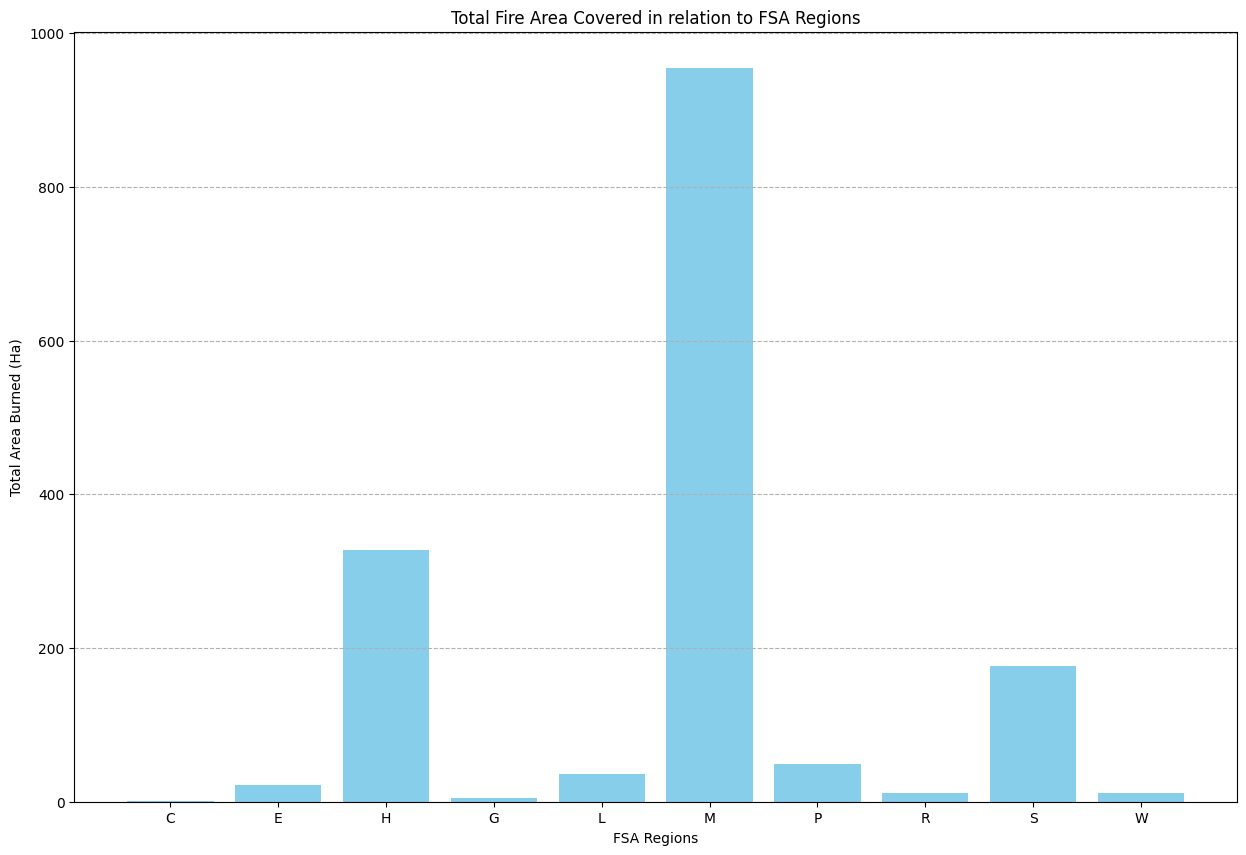

In [61]:
categories = list(weighted_FSA.keys())
values = list(weighted_FSA.values())

for index in range(len(values)):

    total = list(FSA_dict.values())[index]
    values[index] = values[index]/total[0]
    print(total[0])

print(values)
plt.figure(figsize=(15, 10))
plt.bar(categories, values, color='skyblue')
plt.title('Total Fire Area Covered in relation to FSA Regions')
plt.xlabel('FSA Regions')
plt.ylabel('Total Area Burned (Ha)')
plt.grid(axis='y', linestyle='--')
plt.show()


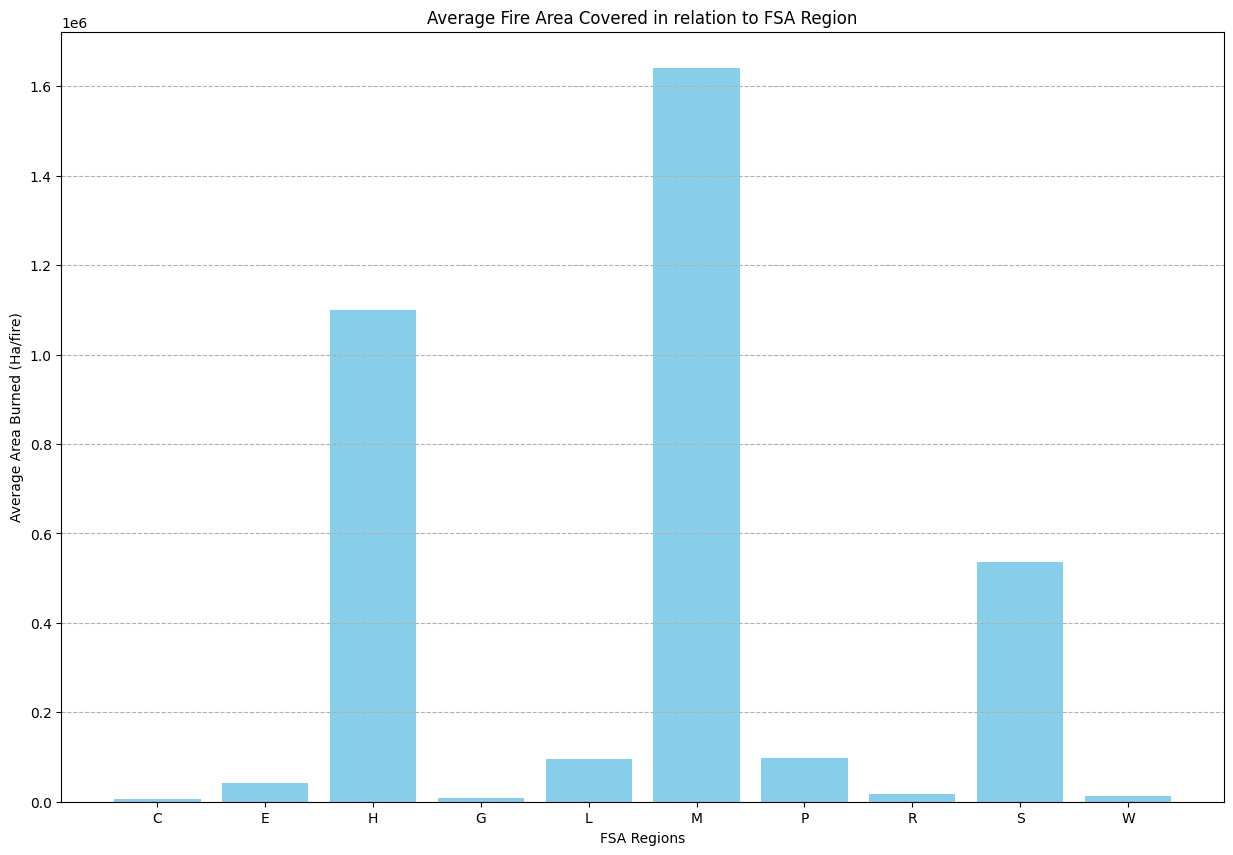

In [62]:
categories = list(weighted_FSA.keys())
values = list(weighted_FSA.values())

fig, ax = plt.subplots(figsize=(15, 10))
ax.yaxis.grid(True, linestyle='--')

ax.bar(categories, values, color='skyblue')
ax.set_title('Average Fire Area Covered in relation to FSA Region')
ax.set_xlabel('FSA Regions')
ax.set_ylabel('Average Area Burned (Ha/fire)')
plt.show()


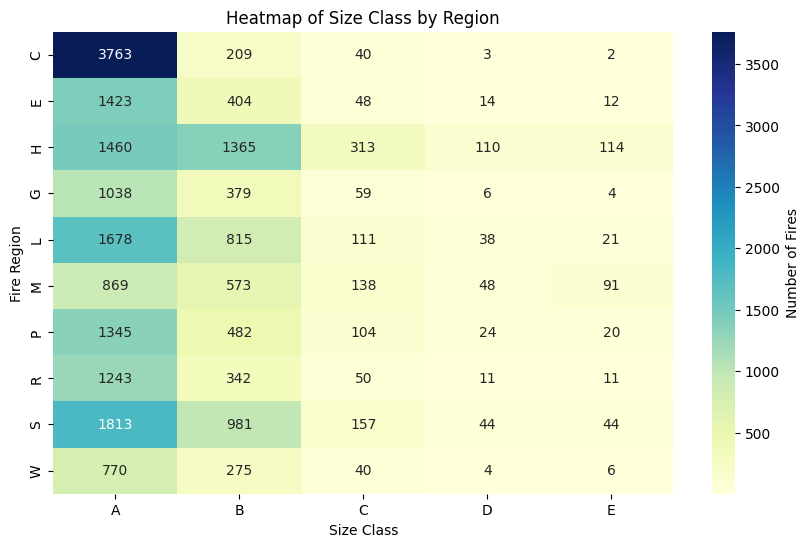

In [63]:
df_heatmap = pd.DataFrame(FSA_dict).T
df_heatmap.columns = ['Total', 'Size Class Count']

# Extracting Size Class information
size_class = df_heatmap.columns

df_heatmap = df_heatmap['Size Class Count'].apply(pd.Series)

# Count of Size Classes
count_size_classes = len(df_heatmap.columns)

plt.figure(figsize=(10, 6))
sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Number of Fires'})
plt.title('Heatmap of Size Class by Region')
plt.xlabel('Size Class')
plt.ylabel('Fire Region')
plt.show()

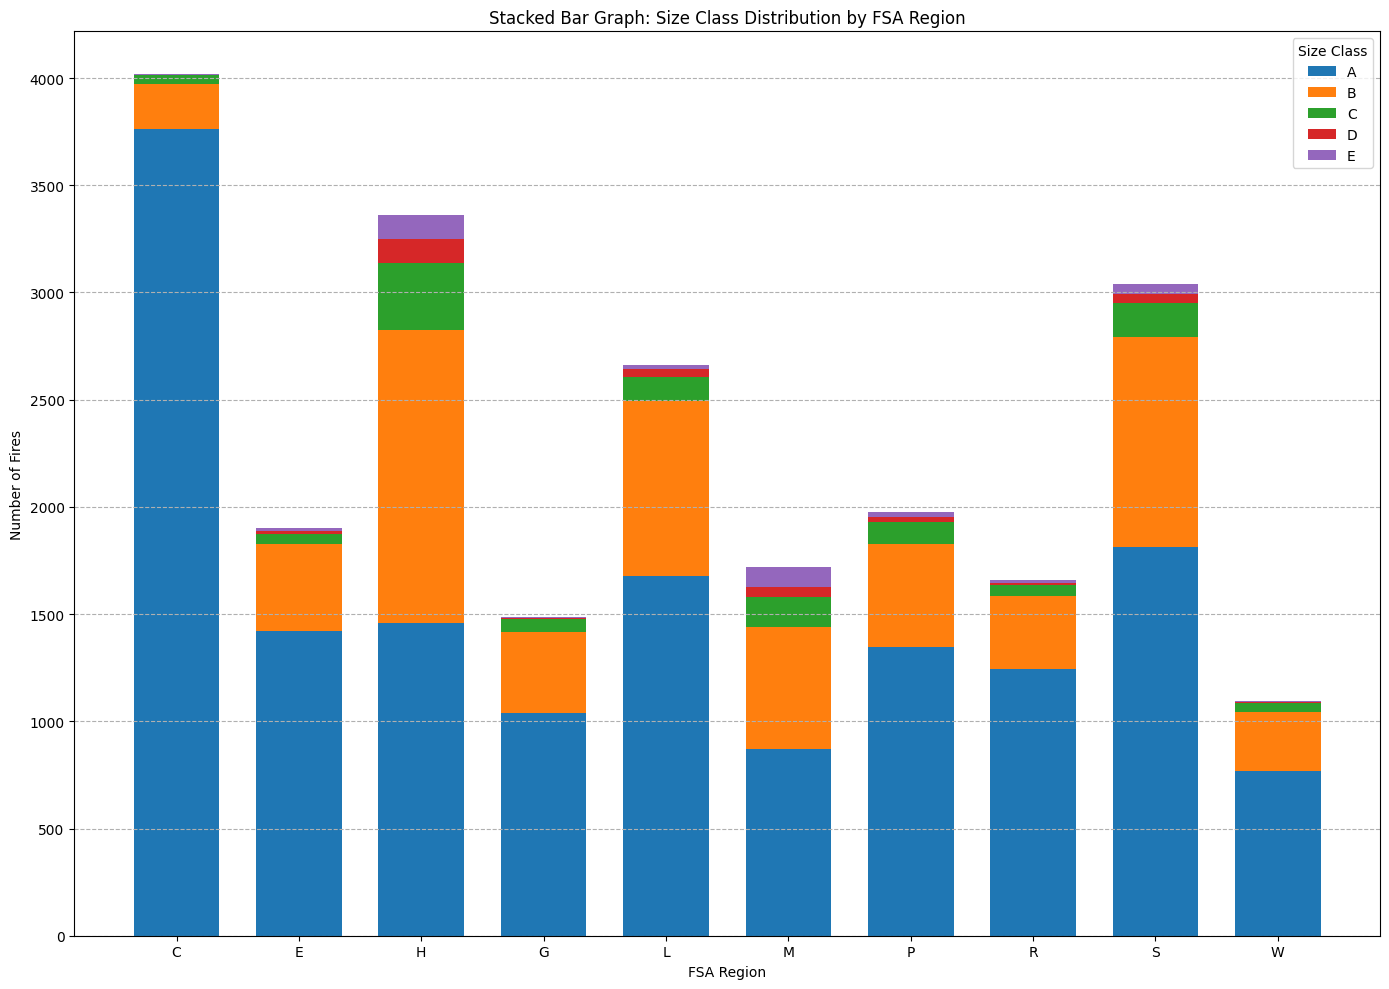

In [64]:
labels = list(FSA_dict.keys())
classes = list(FSA_dict[labels[0]][1].keys())
data = [[FSA_dict[fsa][1][cls] for fsa in labels] for cls in classes]

fig, ax = plt.subplots(figsize=(14, 10))
width = 0.7  # Increase the width for better visibility
ind = np.arange(len(labels))
bottom = np.zeros(len(labels))

# Use color map for better distinguishability
colors = plt.cm.tab10.colors

for i, cls in enumerate(classes):
    ax.bar(ind, data[i], width, bottom=bottom, label=cls, color=colors[i])
    bottom += np.array(data[i])

ax.set_ylabel('Number of Fires')
ax.set_xlabel('FSA Region')
ax.set_title('Stacked Bar Graph: Size Class Distribution by FSA Region')
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation=0)  # Rotate x-axis labels for better readability
ax.legend(title='Size Class', bbox_to_anchor=(1, 1))  # Move legend outside the plot for clarity
ax.yaxis.grid(True, linestyle='--')


plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [65]:
f_origin_list = {}
count = 0
rest_list = {}

for index in df.index:
    origin = df.loc[index, 'fire_origin']
    size_class = str(df.loc[index, 'size_class'])

    if origin not in f_origin_list:
        f_origin_list[origin] = [{'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]

    f_origin_list[origin][0][size_class] += 1

print(f_origin_list)

indian_reservation_data = {'Indian Reservation': f_origin_list['Indian Reservation']}
other_data = {}

for key, value in f_origin_list.items():
    if key != 'Indian Reservation':
        if not other_data:
            other_data = {k: v for k, v in value[0].items()}
        else:
            for k, v in value[0].items():
                other_data[k] += v

print(indian_reservation_data)

print(other_data)

{'Provincial Land': [{'A': 11317, 'B': 3750, 'C': 736, 'D': 240, 'E': 302}], 'Indian Reservation': [{'A': 1646, 'B': 1091, 'C': 118, 'D': 21, 'E': 7}], 'Private Land': [{'A': 2123, 'B': 863, 'C': 174, 'D': 31, 'E': 6}], 'Provincial Park': [{'A': 184, 'B': 33, 'C': 13, 'D': 4, 'E': 8}], 'Metis Settlement': [{'A': 88, 'B': 42, 'C': 8, 'D': 1, 'E': 0}], 'DND': [{'A': 37, 'B': 44, 'C': 10, 'D': 4, 'E': 2}], 'National Park': [{'A': 1, 'B': 0, 'C': 0, 'D': 1, 'E': 0}], nan: [{'A': 6, 'B': 2, 'C': 1, 'D': 0, 'E': 0}]}
{'Indian Reservation': [{'A': 1646, 'B': 1091, 'C': 118, 'D': 21, 'E': 7}]}
{'A': 13756, 'B': 4734, 'C': 942, 'D': 281, 'E': 318}


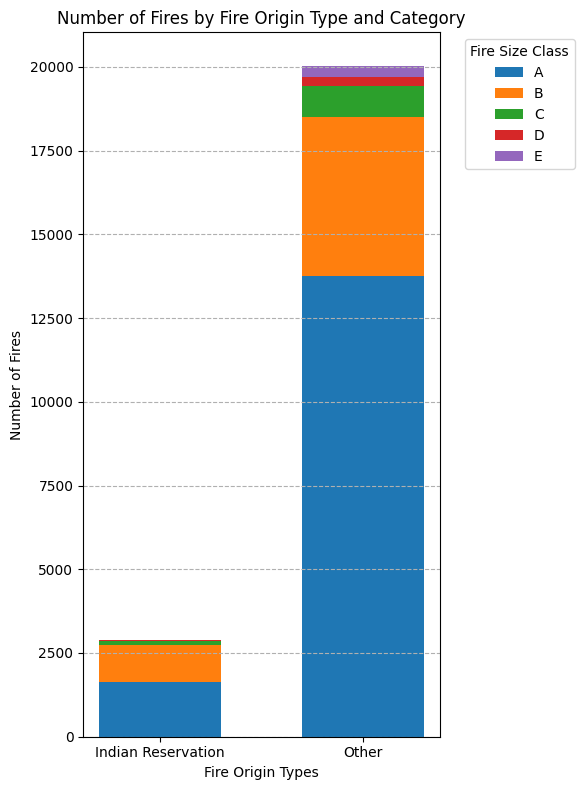

In [66]:
categories = list(other_data.keys())
origin_labels = list(indian_reservation_data.keys()) + ['Other']

fig, ax = plt.subplots(figsize=(6, 8))
bar_width = 0.6

bottom_values = [0] * len(origin_labels)

for category in categories:
    values = [indian_reservation_data[label][0][category] if label in indian_reservation_data else other_data[category] for label in origin_labels]
    ax.bar(origin_labels, values, width=bar_width, label=category, bottom=bottom_values)
    bottom_values = [bottom + value for bottom, value in zip(bottom_values, values)]

ax.set_ylabel('Number of Fires')
ax.set_xlabel('Fire Origin Types')
ax.set_title('Number of Fires by Fire Origin Type and Category')
ax.legend(title='Fire Size Class', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.yaxis.grid(True, linestyle='--')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [67]:
stat_can_data = {'C': [1277415,41355], 'E': [7265,865], 'H': [2300,1250], 'G': [14745,9425], 'L': [5650,1915], 'M': [20,310], 'P': [5265,1200], 'R': [44971,2005], 'S': [4880,1780], 'W': [8595,1260]}
final_pop = {'C': [0, 0], 'E': [0, 0], 'H': [0, 0], 'G': [0, 0], 'L': [0, 0], 'M': [0, 0], 'P': [0, 0], 'R': [0, 0], 'S': [0, 0], 'W': [0, 0]}

weighted_indian = {'C': [0, 0, 0, 0], 
                   'E': [0, 0, 0, 0], 
                   'H': [0, 0, 0, 0], 
                   'G': [0, 0, 0, 0], 
                   'L': [0, 0, 0, 0], 
                   'M': [0, 0, 0, 0], 
                   'P': [0, 0, 0, 0],
                   'R': [0, 0, 0, 0], 
                   'S': [0, 0, 0, 0], 
                   'W': [0, 0, 0, 0]}

for key,value in stat_can_data.items():
    stat_can_data[key].append(stat_can_data[key][0]/stat_can_data[key][1])

for index in df.index:
    region = df.loc[index, 'fire_number']
    region = region[:1]
    if(df.loc[index, 'fire_origin'] == 'Indian Reservation'):
        weighted_indian[region][1] +=  df.loc[index, 'current_size']/stat_can_data[region][1]
        weighted_indian[region][3] += 1
    
    else:
        weighted_indian[region][0] +=  df.loc[index, 'current_size']/stat_can_data[region][0]
        weighted_indian[region][2] += 1

for key,value in weighted_indian.items():
    weighted_indian[key][0] = weighted_indian[key][0]/weighted_indian[key][2]
    try:
        weighted_indian[key][1] = weighted_indian[key][1]/weighted_indian[key][3]
    except(ZeroDivisionError):
       weighted_indian[key][1] = 0 

for key,value in weighted_indian.items():
    final_pop[key][0] = 1
    final_pop[key][1] = (weighted_indian[key][1]/weighted_indian[key][0])

print(final_pop)
print(weighted_indian)

{'C': [1, 21.56236840025146], 'E': [1, 0.0], 'H': [1, 0.009199758591531979], 'G': [1, 0.2599740057159525], 'L': [1, 0.06142147039344621], 'M': [1, 0.03140103820977695], 'P': [1, 0.008565190739986316], 'R': [1, 1.1371394437115396], 'S': [1, 0.09444716960499969], 'W': [1, 0.023610385843911452]}
{'C': [1.006834633105065e-06, 2.1709739277143427e-05, 3666, 351], 'E': [0.003032916713882307, 0, 1901, 0], 'H': [0.2094478661502915, 0.0019268698060941843, 2279, 1083], 'G': [0.0003463636413114568, 9.004554326610281e-05, 1433, 53], 'L': [0.009031624990957337, 0.000554735686986795, 1835, 828], 'M': [47.97274147058752, 1.5063938879456702, 1700, 19], 'P': [0.009692588343299512, 8.301886792452829e-05, 1922, 53], 'R': [0.00026438749167755396, 0.000300645445210503, 1521, 136], 'S': [0.040687868271781065, 0.0038428539955307917, 2682, 357], 'W': [0.001344579116830413, 3.1746031746031745e-05, 1092, 3]}


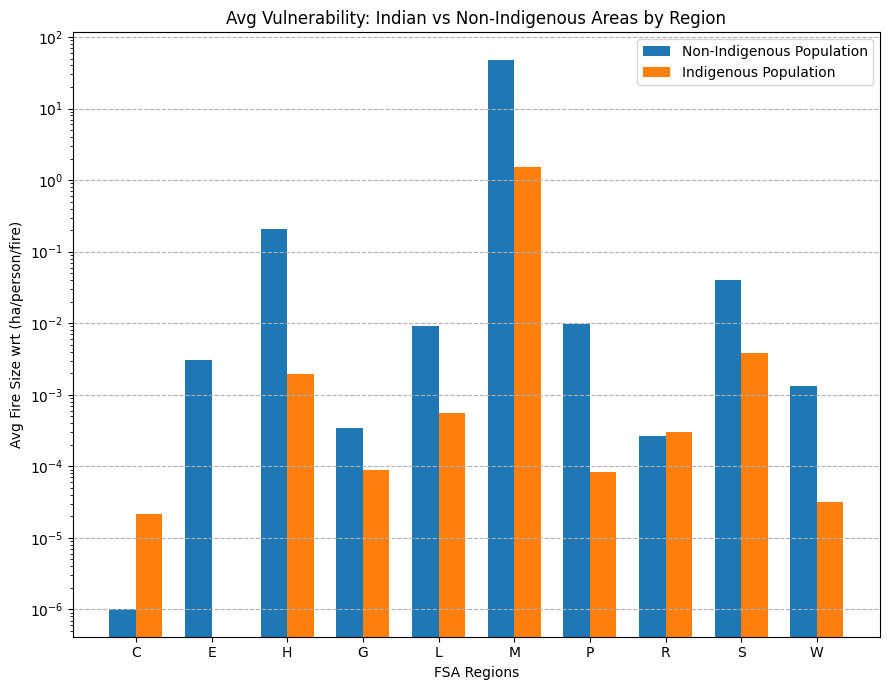

In [68]:
categories = list(weighted_indian.keys())
values1 = [item[0] for item in weighted_indian.values()]
values2 = [item[1] for item in weighted_indian.values()]

bar_width = 0.35
index = np.arange(len(categories))

fig, ax = plt.subplots(figsize = (9,7))

bar1 = ax.bar(index, values1, bar_width, label='Non-Indigenous Population')
bar2 = ax.bar(index + bar_width, values2, bar_width, label='Indigenous Population')

ax.set_xlabel('FSA Regions')
ax.set_ylabel('Avg Fire Size wrt (ha/person/fire)')
ax.set_title('Avg Vulnerability: Indian vs Non-Indigenous Areas by Region')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()
ax.set_yscale('log')
ax.yaxis.grid(True, linestyle='--')

plt.tight_layout()
plt.show()

In [69]:
import datetime as datetime
import time
df['total_time'] = np.nan
#df['elapsed_time'] = np.nan
df['ex_fs_date'] = pd.to_datetime(df['ex_fs_date'], errors='coerce')
df['fire_start_date'] = pd.to_datetime(df['fire_start_date'], errors='coerce')

df['total_time'] = df['ex_fs_date'] - df['fire_start_date']

#do not understand how this conversion is occuring, errors = 'coerce' seems to populate all the rows for 'ia_arrival_at_first_date', therefore ignoring for now 
#df['ia_arrival_at_fire_date'] = pd.to_datetime(df['ex_fs_date'], dayfirst=True,errors='coerce')
#df['ex_fs_date'] - df['ia_arrival_at_fire_date']

#removing the first row since it has incorrect information (11 year gap)
df = df.drop(0)

df

C:\Users\Aarna\AppData\Local\Temp\ipykernel_15052\2798713993.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ex_fs_date'] = pd.to_datetime(df['ex_fs_date'], errors='coerce')
C:\Users\Aarna\AppData\Local\Temp\ipykernel_15052\2798713993.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['fire_start_date'] = pd.to_datetime(df['fire_start_date'], errors='coerce')


,fire_year,fire_number,fire_name,current_size,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,industry_identifier_desc,...,first_bucket_drop_date,bh_fs_date,bh_hectares,uc_fs_date,uc_hectares,to_fs_date,to_hectares,ex_fs_date,ex_hectares,total_time
1,2021,RWF005,NaN,0.01,A,52.692262,-116.118960,Provincial Land,Forest Industry,NaN,...,NaN,3/30/21 14:30,0.01,3/30/21 14:30,0.01,3/30/21 14:35,0.01,2021-04-09 08:30:00,0.01,380 days 00:30:00
2,2021,LWF014,NaN,0.10,A,55.937050,-110.719950,Indian Reservation,Incendiary,NaN,...,NaN,4/16/21 16:57,0.10,4/16/21 16:57,0.10,NaN,NaN,2021-04-17 14:15:00,0.10,365 days 21:55:00
3,2021,MWF002,NaN,0.01,A,56.425933,-111.160750,Indian Reservation,Resident,NaN,...,NaN,4/17/21 15:20,0.01,4/17/21 15:20,0.01,NaN,NaN,2021-04-17 15:24:00,0.01,365 days 22:24:00
4,2021,EWF014,NaN,7.13,C,53.693450,-116.058633,Private Land,Resident,NaN,...,NaN,4/1/21 19:10,7.13,4/2/21 11:00,7.13,4/2/21 15:52,7.13,2021-04-12 14:30:00,7.13,162 days 04:30:00
5,2021,GWF027,NaN,0.02,A,55.010900,-117.379800,Private Land,Resident,NaN,...,NaN,5/6/21 17:20,0.01,5/6/21 17:30,0.01,5/6/21 17:45,0.02,2021-05-20 11:56:00,0.02,199 days 23:56:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22909,2006,CWF231,NaN,0.10,A,51.161883,-114.869317,Indian Reservation,Resident,NaN,...,NaN,3/11/07 17:35,0.01,3/11/07 17:45,0.01,NaN,NaN,2007-03-11 18:00:00,0.10,0 days 00:50:00
22910,2006,CWF232,NaN,0.01,A,51.084150,-115.392633,Provincial Park,Undetermined,NaN,...,NaN,3/19/07 10:25,0.01,3/19/07 10:25,0.01,NaN,NaN,2007-03-19 10:40:00,0.01,6 days 00:40:00
22911,2006,CWF233,NaN,0.70,B,51.333900,-114.997667,Provincial Land,Recreation,NaN,...,NaN,3/26/07 2:00,0.70,3/26/07 2:00,0.70,NaN,NaN,2007-03-26 12:00:00,0.70,0 days 20:00:00
22912,2006,CWF234,NaN,0.01,A,51.071467,-115.316300,Provincial Land,Resident,NaN,...,NaN,3/28/07 11:00,0.01,3/28/07 11:00,0.01,NaN,NaN,2007-03-28 11:30:00,0.01,0 days 07:35:00


In [70]:
df['total_time']

1       380 days 00:30:00
2       365 days 21:55:00
3       365 days 22:24:00
4       162 days 04:30:00
5       199 days 23:56:00
               ...       
22909     0 days 00:50:00
22910     6 days 00:40:00
22911     0 days 20:00:00
22912     0 days 07:35:00
22913                 NaT
Name: total_time, Length: 22913, dtype: timedelta64[ns]

In [71]:
#isolating dataset 

df_model = df[['current_size', 'fire_spread_rate', 'total_time']]

#removing NAT rows in df 
df_model.dropna(subset =['total_time'],inplace=True, ignore_index=True)

df_model

C:\Users\Aarna\AppData\Local\Temp\ipykernel_15052\2243468131.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.dropna(subset =['total_time'],inplace=True, ignore_index=True)


,current_size,fire_spread_rate,total_time
0,0.01,0.0,380 days 00:30:00
1,0.10,0.5,365 days 21:55:00
2,0.01,0.0,365 days 22:24:00
3,7.13,5.0,162 days 04:30:00
4,0.02,0.0,199 days 23:56:00
...,...,...,...
22286,0.01,0.0,0 days 15:30:00
22287,0.10,0.0,0 days 00:50:00
22288,0.01,0.0,6 days 00:40:00
22289,0.70,0.1,0 days 20:00:00


In [72]:
#turning 'total_time' into float dtype 
print(type(df_model.loc[0, 'total_time']))

for index in df_model.index:
    df_model.at[index, 'total_time'] = df_model.at[index, 'total_time'].total_seconds()

C:\Users\Aarna\AppData\Local\Temp\ipykernel_15052\97591098.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32833800.0' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  df_model.at[index, 'total_time'] = df_model.at[index, 'total_time'].total_seconds()


<class 'pandas._libs.tslibs.timedeltas.Timedelta'>


In [73]:
df_model

,current_size,fire_spread_rate,total_time
0,0.01,0.0,32833800.0
1,0.10,0.5,31614900.0
2,0.01,0.0,31616640.0
3,7.13,5.0,14013000.0
4,0.02,0.0,17279760.0
...,...,...,...
22286,0.01,0.0,55800.0
22287,0.10,0.0,3000.0
22288,0.01,0.0,520800.0
22289,0.70,0.1,72000.0


In [74]:
#dropping na values from 'fire_spread_rate'

df_model.dropna(subset =['fire_spread_rate'],inplace=True, ignore_index=True)

C:\Users\Aarna\AppData\Local\Temp\ipykernel_15052\54243234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.dropna(subset =['fire_spread_rate'],inplace=True, ignore_index=True)


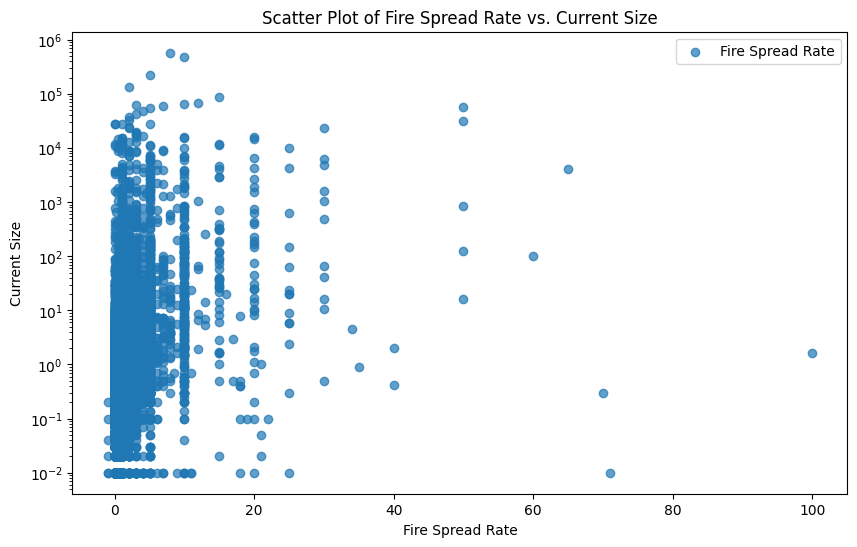

In [75]:
#plotting to see if relationship is linear or non-linear 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatter plot for 'fire_spread_rate' vs. 'current_size'
plt.scatter(df_model['fire_spread_rate'], df_model['current_size'], label='Fire Spread Rate', alpha=0.7)

# Set plot labels and title
plt.xlabel('Fire Spread Rate')
plt.ylabel('Current Size')
plt.title('Scatter Plot of Fire Spread Rate vs. Current Size')

#removing outliers
plt.yscale('log')

# Display legend
plt.legend()

# Show the plot
plt.show()

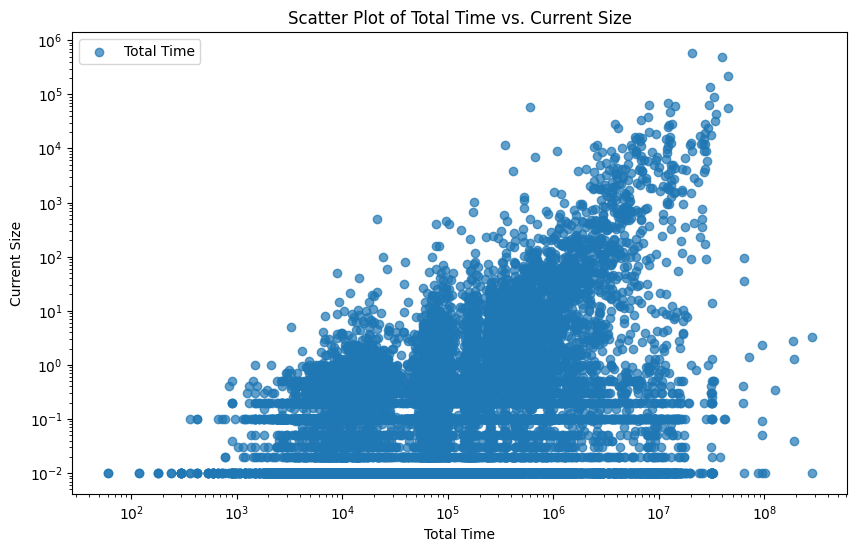

In [76]:
plt.figure(figsize=(10, 6))

# Scatter plot for 'total_time' vs. 'current_size'
plt.scatter(df_model['total_time'], df_model['current_size'], label='Total Time', alpha=0.7)

# Set plot labels and title
plt.xlabel('Total Time')
plt.ylabel('Current Size')
plt.title('Scatter Plot of Total Time vs. Current Size')

#removing outliers
plt.yscale('log')
plt.xscale('log')

# Display legend
plt.legend()

# Show the plot
plt.show()

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#turning into array 
x = df_model[['total_time', 'fire_spread_rate']].to_numpy()

y = df_model['current_size'].to_numpy()


#spliting data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

#reshaping 
y_train = y_train.reshape(-1, 1)

#scaling the features (using standardization)

from sklearn.preprocessing import StandardScaler

stndx = StandardScaler()
stndy = StandardScaler()

X_train = stndx.fit_transform(X_train)

y_train = stndy.fit_transform(y_train)

X_test = stndx.transform(X_test)


In [78]:
#let's try a variety of machine learning algorithms to see which one can yield the best results 

from sklearn.metrics import r2_score 
#1 - linear regression 
model = LinearRegression().fit(X_train, y_train)

y_pred_linear = stndy.inverse_transform(model.predict(X_test).reshape(-1,1))

print("LinearRegression: ", r2_score(y_test, y_pred_linear))

#2 - ridge regression 

from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)

ridge.fit(X_train, y_train)

y_pred_ridge = stndy.inverse_transform(ridge.predict(X_test).reshape(-1,1))

print("Ridge Regression: ", r2_score(y_test, y_pred_ridge))

#using non linear algorithms 

#3 - using SVR (SVM regression) - handles noise better 

from sklearn.svm import SVR

svr = SVR(kernel='rbf', gamma = 'auto', C=100, max_iter=100000, tol=1e-5)

svr.fit(X_train, y_train.ravel())

y_pred_standardized_svr = svr.predict(X_test)

y_pred_svr = stndy.inverse_transform(y_pred_standardized_svr.reshape(-1, 1))

print("SVR: ", r2_score(y_test, y_pred_svr))

#4 - #using random forest regressor 

from sklearn.ensemble import RandomForestRegressor

rng = RandomForestRegressor(n_estimators=100,min_samples_split=20, min_samples_leaf=12, max_features='sqrt', random_state=12)

rng.fit(X_train, y_train.ravel())

y_pred_standardized = rng.predict(X_test)

# Inverse transform the standardized predictions
y_pred_rng = stndy.inverse_transform(y_pred_standardized.reshape(-1, 1))

print("Random Forest Regressor: ", r2_score(y_test, y_pred_rng))


LinearRegression:  -0.14015063846636688
Ridge Regression:  -0.1401233531212278


c:\Users\Aarna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR:  -1.9379007188144448
Random Forest Regressor:  0.2052526526762598


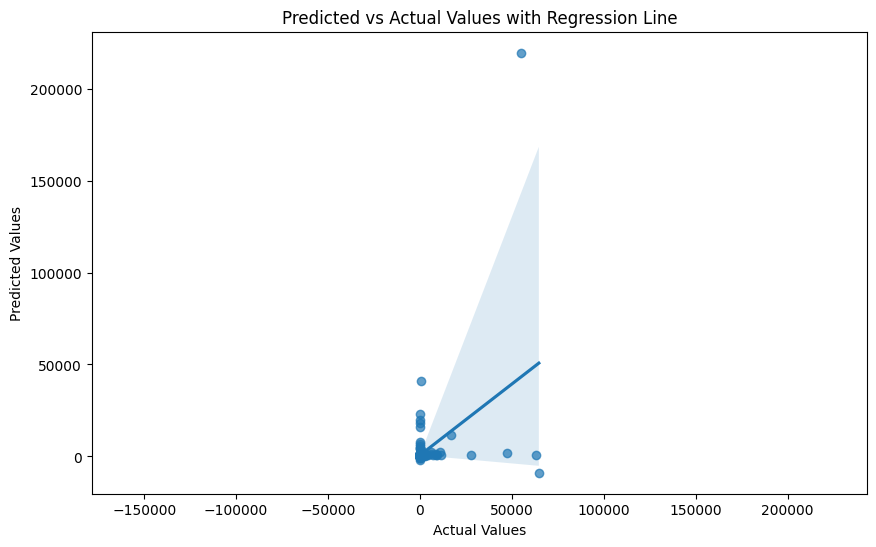

In [79]:
#SVR fits the best 

data = {'Actual': y_test.flatten(), 'Predicted': y_pred_svr.flatten()}

df = pd.DataFrame(data)

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='Actual', y='Predicted', data=df, scatter_kws={'alpha':0.7})
plt.title('Predicted vs Actual Values with Regression Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.axis('equal')
plt.show()

In [80]:
#using k folds cross validation methods 

#using gradient boost alogorithms 
'''from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

num_folds = 6
num_repeats = 3  # Adjust as needed
rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=10)

xgb = XGBRegressor(learning_rate = 0.02, max_depth = 3, n_estimators = 150)
model = LinearRegression()
ridge = Ridge(alpha=1.0)
svr = SVR(kernel='rbf', gamma = 'auto', C=100, max_iter=100000, tol=1e-5)
rng = RandomForestRegressor(n_estimators=100,min_samples_split=20, min_samples_leaf=12, max_features='sqrt', random_state=12)
# Lists to store cross-validation results
r2_scores_model = []
r2_scores_ridge = []
r2_scores_svr= []
r2_scores_rng = []
r2_scores_xgb = []

# Perform repeated k-fold cross-validation
for train_index, test_index in rkf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    ridge.fit(X_train, y_train)
    svr.fit(X_train, y_train)
    rng.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_xgb = xgb.predict(X_test)
    y_pred_model = stndy.inverse_transform((model.predict(X_test)).reshape(-1,1))
    y_pred_ridge = stndy.inverse_transform((ridge.predict(X_test)).reshape(-1,1))
    y_pred_svr = stndy.inverse_transform((svr.predict(X_test)).reshape(-1,1))
    y_pred_rng = stndy.inverse_transform((rng.predict(X_test)).reshape(-1,1))
    # Inverse transform the standardized predictions

    # Evaluate and store the R-squared score
    r2_xgb = r2_score(y_test, y_pred_xgb)
    r2_model = r2_score(y_test, y_pred_model)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    r2_svr = r2_score(y_test, y_pred_svr)
    r2_rng = r2_score(y_test, y_pred_rng)

    r2_scores_xgb.append(r2_xgb)
    r2_scores_model.append(r2_model)
    r2_scores_ridge.append(r2_ridge)
    r2_scores_svr.append(r2_svr)
    r2_scores_rng.append(r2_rng)

# Calculate the average R-squared score across all folds and repetitions
average_r2_xgb = np.mean(r2_scores_xgb)
average_r2_model = np.mean(r2_scores_model)
average_r2_ridge = np.mean(r2_scores_ridge)
average_r2_svr = np.mean(r2_scores_svr)
average_r2_rng = np.mean(r2_scores_rng)
print("Average R-squared Score for XGB:", average_r2_xgb)
print("Average R-squared Score for Linear Regression:", average_r2_model)
print("Average R-squared Score for Ridge Regression:", average_r2_ridge)
print("Average R-squared Score for SVR:", average_r2_svr)
print("Average R-squared Score for RNG:", average_r2_rng)'''

'from sklearn.model_selection import cross_val_score\nfrom sklearn.model_selection import RepeatedKFold\nfrom xgboost import XGBRegressor\n\nnum_folds = 6\nnum_repeats = 3  # Adjust as needed\nrkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=10)\n\nxgb = XGBRegressor(learning_rate = 0.02, max_depth = 3, n_estimators = 150)\nmodel = LinearRegression()\nridge = Ridge(alpha=1.0)\nsvr = SVR(kernel=\'rbf\', gamma = \'auto\', C=100, max_iter=100000, tol=1e-5)\nrng = RandomForestRegressor(n_estimators=100,min_samples_split=20, min_samples_leaf=12, max_features=\'sqrt\', random_state=12)\n# Lists to store cross-validation results\nr2_scores_model = []\nr2_scores_ridge = []\nr2_scores_svr= []\nr2_scores_rng = []\nr2_scores_xgb = []\n\n# Perform repeated k-fold cross-validation\nfor train_index, test_index in rkf.split(x):\n    X_train, X_test = x[train_index], x[test_index]\n    y_train, y_test = y[train_index], y[test_index]\n\n    model.fit(X_train, y_train)\n    ri

In [81]:
#removing outliers from data 

from scipy.stats import zscore
numeric_columns = df_model.select_dtypes(include=['float64', 'int64'])
z_scores = zscore(numeric_columns)
z_scores_df = pd.DataFrame(z_scores, columns=numeric_columns.columns, index=numeric_columns.index)

outlier_threshold = 1.5 #(95% percentile only)
outliers = (np.abs(z_scores_df) > outlier_threshold).any(axis=1)

# Remove outliers from the original DataFrame
df_model= df_model[~outliers]

df_model.reset_index(inplace=True, drop=True)
df_model

,current_size,fire_spread_rate,total_time
0,0.01,0.0,32833800.0
1,0.10,0.5,31614900.0
2,0.01,0.0,31616640.0
3,0.02,0.0,17279760.0
4,0.10,0.0,9273360.0
...,...,...,...
19153,0.01,0.0,55800.0
19154,0.10,0.0,3000.0
19155,0.01,0.0,520800.0
19156,0.70,0.1,72000.0


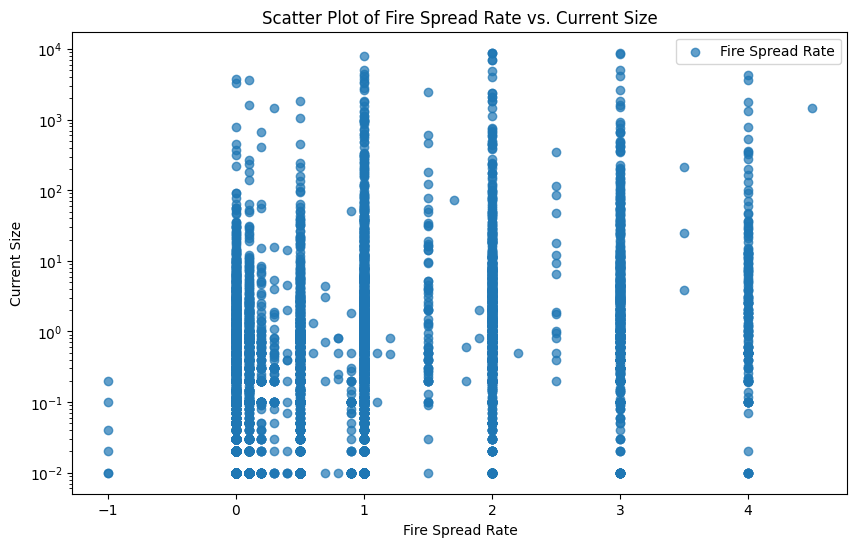

In [82]:
#replotting to see 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatter plot for 'fire_spread_rate' vs. 'current_size'
plt.scatter(df_model['fire_spread_rate'], df_model['current_size'], label='Fire Spread Rate', alpha=0.7)

# Set plot labels and title
plt.xlabel('Fire Spread Rate')
plt.ylabel('Current Size')
plt.title('Scatter Plot of Fire Spread Rate vs. Current Size')

#removing outliers
plt.yscale('log')

# Display legend
plt.legend()

# Show the plot
plt.show()

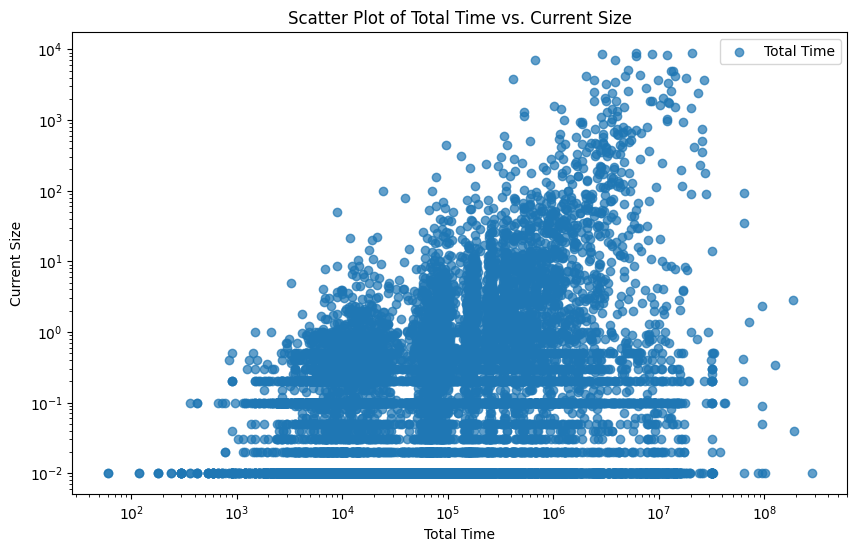

In [83]:
plt.figure(figsize=(10, 6))

# Scatter plot for 'total_time' vs. 'current_size'
plt.scatter(df_model['total_time'], df_model['current_size'], label='Total Time', alpha=0.7)

# Set plot labels and title
plt.xlabel('Total Time')
plt.ylabel('Current Size')
plt.title('Scatter Plot of Total Time vs. Current Size')

#removing outliers
plt.yscale('log')
plt.xscale('log')

# Display legend
plt.legend()

# Show the plot
plt.show()

In [84]:
#resplit the data, since df was changed 

x = df_model[['total_time', 'fire_spread_rate']].to_numpy()

y = df_model['current_size'].to_numpy()


#spliting data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

#reshaping 
y_train = y_train.reshape(-1, 1)

#scaling the features (using standardization)

from sklearn.preprocessing import StandardScaler

stndx = StandardScaler()
stndy = StandardScaler()

X_train = stndx.fit_transform(X_train)

y_train = stndy.fit_transform(y_train)

X_test = stndx.transform(X_test)

In [85]:
# now trying the same algorithms but with the new outlier free data 

#1 - linear regression 

model = LinearRegression().fit(X_train, y_train)

y_pred_linear = stndy.inverse_transform(model.predict(X_test))

print("LinearRegression: ", r2_score(y_test, y_pred_linear))

#2 - ridge regression 


ridge = Ridge(alpha=1.0)

ridge.fit(X_train, y_train)

y_pred_ridge = stndy.inverse_transform(ridge.predict(X_test))

print("Ridge Regression: ", r2_score(y_test, y_pred_ridge))

#using non linear algorithms 

#3 - using SVR (SVM regression) - handles noise better 

svr = SVR(kernel='rbf', gamma = 'auto', C=100, max_iter=10000000, tol=1e-5)

svr.fit(X_train, y_train.ravel())

y_pred_standardized = svr.predict(X_test)

y_pred_svr = stndy.inverse_transform(y_pred_standardized.reshape(-1, 1))

print("SVR: ", r2_score(y_test, y_pred_svr))

#4 - #using random forest regressor 


rng = RandomForestRegressor(n_estimators=100,min_samples_split=20, min_samples_leaf=12, max_features='sqrt', random_state=12)

rng.fit(X_train, y_train.ravel())

y_pred_standardized = rng.predict(X_test)

# Inverse transform the standardized predictions
y_pred_rng = stndy.inverse_transform(y_pred_standardized.reshape(-1, 1))

print("Random Forest Regressor: ", r2_score(y_test, y_pred_rng))

LinearRegression:  0.020138117215847906
Ridge Regression:  0.020137795376522494
SVR:  -0.00923329294980424
Random Forest Regressor:  0.11619570745178309


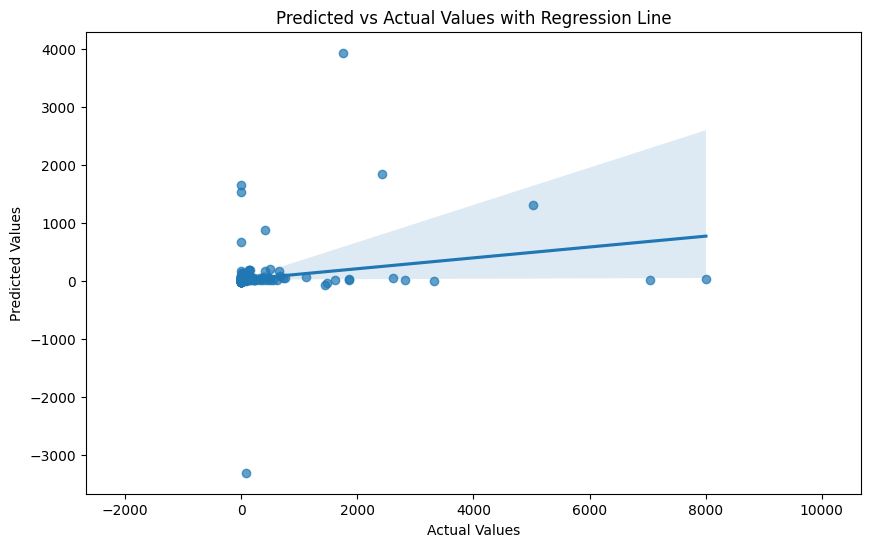

In [86]:
data = {'Actual': y_test.flatten(), 'Predicted': y_pred_svr.flatten()}

df = pd.DataFrame(data)

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='Actual', y='Predicted', data=df, scatter_kws={'alpha':0.7})
plt.title('Predicted vs Actual Values with Regression Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.axis('equal')

plt.show()

In [87]:
#using gradient boost alogorithms 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

num_folds = 6
num_repeats = 3  # Adjust as needed
rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=10)

# Initialize XGBoost Regressor
xgb = XGBRegressor(learning_rate = 0.02, max_depth = 3, n_estimators = 150)

# Lists to store cross-validation results
r2_scores = []

# Perform repeated k-fold cross-validation
for train_index, test_index in rkf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the XGBoost model
    xgb.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = xgb.predict(X_test)

    # Inverse transform the standardized predictions

    # Evaluate and store the R-squared score
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# Calculate the average R-squared score across all folds and repetitions
average_r2 = np.mean(r2_scores)
print("Average R-squared Score:", average_r2)


Average R-squared Score: 0.06618280673001169
